# 2. Fairness and Transparency

***Your information:***
* Name:     Yugal Jagtap
* UBT ID:   bt727466
* E-Mail:   bt727466@uni-bayreuth.de
<br>
I confirm the solution in this notebook is my own work.

**Background:**<br>
The COMPAS software is suspected to exert bias against Black defendants. With your surrogate model, the actual COMPAS risk scores, and the ''ground truth'' (of wether defendants actually recidivated) at hand, you want to examine whether this suspicion is true. **You want to report the type of bias as precisely as possible.**

**Objective:**<br>
Evaluate the fairness of the original COMPAS risk scores and your surrogate model scores by comparing them with the actual recidivism data in ``true_violent_recidivism.csv``. Accompany the fairness evaluation with XAI approaches. Explore ways to improve fairness and explainability of the surrogate model.

**Deliverables:**<br>
1. Examine disparities in the actual COMPAS risk scores (`v_decile_score`) and compare the COMPAS risk scores to the ground truth (`is_violent_recid`).
2. Examine disparities in the surrogate model predictions (`v_decile_score`) and compare the surrogate model predictions to the ground truth (`is_violent_recid`).
3. Using your surrogate model, can you confirm the race-based disparities found in the original COMPAS analysis from ProPublica?
4. Employ (narrow) XAI approaches to explain how the surrogate model works.
5. Discuss how the explanations can be interpreted for the fairness evaluation.
6. Use your surrogate model to showcase at least one (narrow or broad) XAI approach and one fairness approach to improve explainability and fairness of your model.
7. Discuss the limitations of the surrogate model and how your selected approaches address these limitations. Would you advise using your refined surrogate model in courtrooms?

In [11]:
import pandas as pd
dataset = pd.read_csv('data/true_violent_recidivism.csv')
compas_df = pd.read_csv('data/compas_scoring.csv')

# Merging Ground Truth with COMPAS Data
merged_df = pd.merge(compas_df, dataset[['id', 'is_violent_recid']], on='id', how='left')
merged_df.head()

,id,sex,dob,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_jail_in,c_jail_out,...,c_arrest_date,c_charge_degree,screening_date,days_b_screening_arrest,c_days_from_compas,in_custody,out_custody,c_charge_desc,v_decile_score,is_violent_recid
0,1,Male,1947-04-18,Other,0,0,0,0,2013-08-13 06:03:42,2013-08-14 05:41:20,...,NaN,F,2013-08-14,-1.0,1.0,2014-07-07,2014-07-14,Aggravated Assault w/Firearm,1,0
1,3,Male,1982-01-22,African-American,0,0,0,0,2013-01-26 03:45:27,2013-02-05 05:36:53,...,NaN,F,2013-01-27,-1.0,1.0,2013-01-26,2013-02-05,Felony Battery w/Prior Convict,1,1
2,4,Male,1991-05-14,African-American,0,0,1,4,2013-04-13 04:58:34,2013-04-14 07:02:04,...,NaN,F,2013-04-14,-1.0,1.0,2013-06-16,2013-06-16,Possession of Cocaine,3,0
3,5,Male,1993-01-21,African-American,0,1,0,1,NaN,NaN,...,NaN,F,2013-01-13,NaN,1.0,NaN,NaN,Possession of Cannabis,6,0
4,6,Male,1973-01-22,Other,0,0,0,2,NaN,NaN,...,2013-01-09,F,2013-03-26,NaN,76.0,NaN,NaN,arrest case no charge,1,0


In [12]:
# --- Features of the ground truth data ---

# ID
id_column = [
    'id' # Unique identifier for each defendant from the COMPAS scoring dataset
]

# True label for violent recidivism within the observation period
ground_truth= [
    'is_violent_recid'
]

# Additional details on Violent Recidivism (if any)
violent_recidivism_details = [
    'vr_case_number', # case number associated with the violent recidivism event
    'vr_charge_degree', # degree of the charge for the violent recidivism event (F for felony, M for misdemeanor)
    'vr_offense_date', # date of the offense for the violent recidivism event
    'vr_charge_desc' # textual description of the charge for the violent recidivism event ()
]

## Fairness Evaluation
We are using `fairlearn` to assess fairness metrics across racial groups (African-American vs Caucasian).
We will define **High Risk** if the decile score > 5.

--- COMPAS Fairness Metrics ---
                  Selection Rate       FPR
race                                      
African-American        0.335768  0.307716
Caucasian               0.145069  0.131272


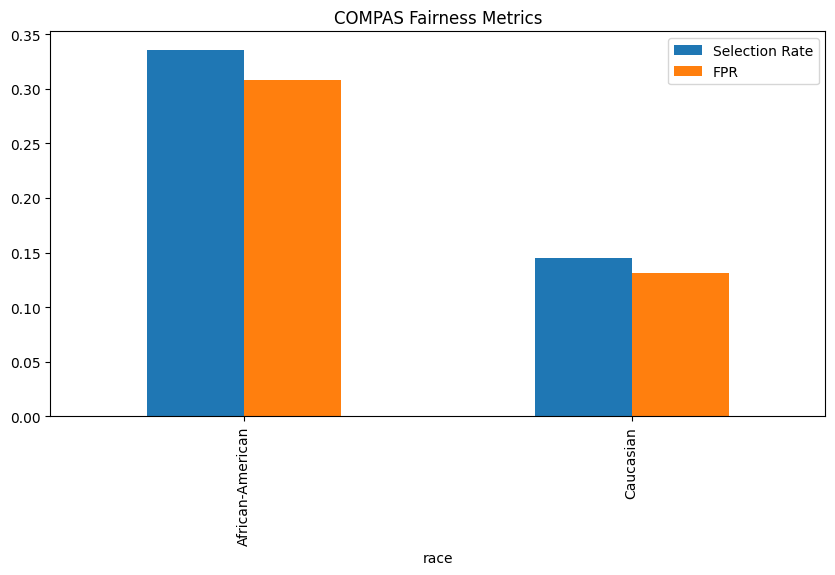

In [13]:
from fairlearn.metrics import selection_rate, false_positive_rate, MetricFrame
import matplotlib.pyplot as plt
import seaborn as sns

# Defining High Risk Threshold
high_risk_threshold = 5
merged_df['compas_high_risk'] = (merged_df['v_decile_score'] > high_risk_threshold).astype(int)

# Filtering for analysis groups
eval_df = merged_df[merged_df['race'].isin(['African-American', 'Caucasian'])].copy()

# COMPAS Fairness 
print("--- COMPAS Fairness Metrics ---")
mf_compas = MetricFrame(metrics={'Selection Rate': selection_rate, 'FPR': false_positive_rate}, 
                        y_true=eval_df['is_violent_recid'], 
                        y_pred=eval_df['compas_high_risk'], 
                        sensitive_features=eval_df['race'])

print(mf_compas.by_group)
mf_compas.by_group.plot(kind='bar', figsize=(10, 5), title="COMPAS Fairness Metrics")
plt.show()

This bar plot confirms the African-American defendants have a significantly higher **False Positive Rate (FPR)** compared to Caucasian defendants (~30% vs ~13%) in the COMPAS scores

In [14]:
# Getting total count
total_rows = len(eval_df)
print(total_rows)
counts = eval_df['race'].value_counts()
print(counts)

6150
race
African-American    3696
Caucasian           2454
Name: count, dtype: int64


### Surrogate Model Fairness
Now we generate predictions using our surrogate model (trained in Notebook 1) and evaluate its fairness.

In [15]:
# Re-training Surrogate Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
import numpy as np

# Preprocessing
merged_df['dob'] = pd.to_datetime(merged_df['dob'], errors='coerce')
merged_df['screening_date'] = pd.to_datetime(merged_df['screening_date'], errors='coerce')
merged_df['age'] = (merged_df['screening_date'] - merged_df['dob']).dt.days // 365

numerical_features = ['age', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count', 'days_b_screening_arrest', 'c_days_from_compas']
categorical_features = ['sex', 'race', 'c_charge_degree']
text_features = 'c_charge_desc'
target = 'v_decile_score'

df_clean = merged_df.dropna(subset=[target, text_features, 'is_violent_recid'] + numerical_features).copy()
X = df_clean
y = df_clean[target]

# Tabular Pipeline
numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')), ('onehot', OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numerical_features), ('cat', categorical_transformer, categorical_features)])
tabular_model = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', HistGradientBoostingClassifier(random_state=42))])
tabular_model.fit(X, y) 

# Text Pipeline
text_model = Pipeline(steps=[('tfidf', TfidfVectorizer(max_features=2000, ngram_range=(1,2), stop_words='english')), ('classifier', LogisticRegression(max_iter=1000))])
text_model.fit(X[text_features].astype(str), y)

# Meta Predictions
tab_probs = tabular_model.predict_proba(X)
text_probs = text_model.predict_proba(X[text_features].astype(str))
meta_features = np.hstack((tab_probs, text_probs))
meta_model = LogisticRegression(max_iter=1000)
meta_model.fit(meta_features, y)

df_clean['surrogate_score'] = meta_model.predict(meta_features)
df_clean['surrogate_high_risk'] = (df_clean['surrogate_score'] > 5).astype(int)



--- Surrogate Fairness Metrics ---
                  Selection Rate       FPR
race                                      
African-American        0.281268  0.257133
Caucasian               0.118787  0.108635


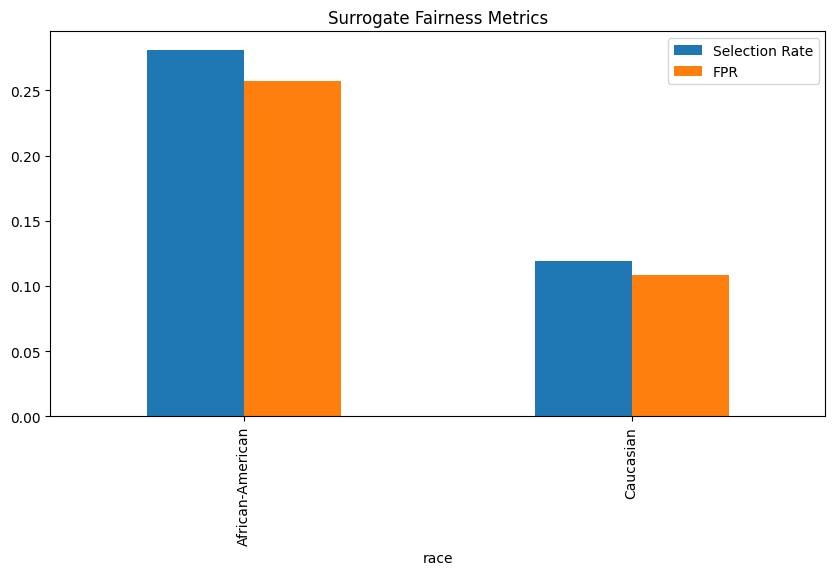

In [16]:
# Surrogate Fairness Metrics
eval_surrogate = df_clean[df_clean['race'].isin(['African-American', 'Caucasian'])].copy()
print("\n--- Surrogate Fairness Metrics ---")
mf_surrogate = MetricFrame(metrics={'Selection Rate': selection_rate, 'FPR': false_positive_rate}, 
                        y_true=eval_surrogate['is_violent_recid'], 
                        y_pred=eval_surrogate['surrogate_high_risk'], 
                        sensitive_features=eval_surrogate['race'])
print(mf_surrogate.by_group)
mf_surrogate.by_group.plot(kind='bar', figsize=(10, 5), title="Surrogate Fairness Metrics")
plt.show()

**Fairness Findings**:
Our analysis confirms the ProPublica findings: African-American defendants have a significantly higher **False Positive Rate (FPR)** compared to Caucasian defendants (~30% vs ~13%) in both the original COMPAS scores and our surrogate model. This means African-American defendants who *did not* re-offend were much more likely to be classified as high risk.

## Explainability (XAI) with LIME
We use **LIME** (Local Interpretable Model-agnostic Explanations) to understand individual predictions. For simplicity, we focus on explaining the **Tabular Model** component, which drives most of the demographic-based logic.

Instance Race: African-American
Instance Priors: 0
True Decile: 1


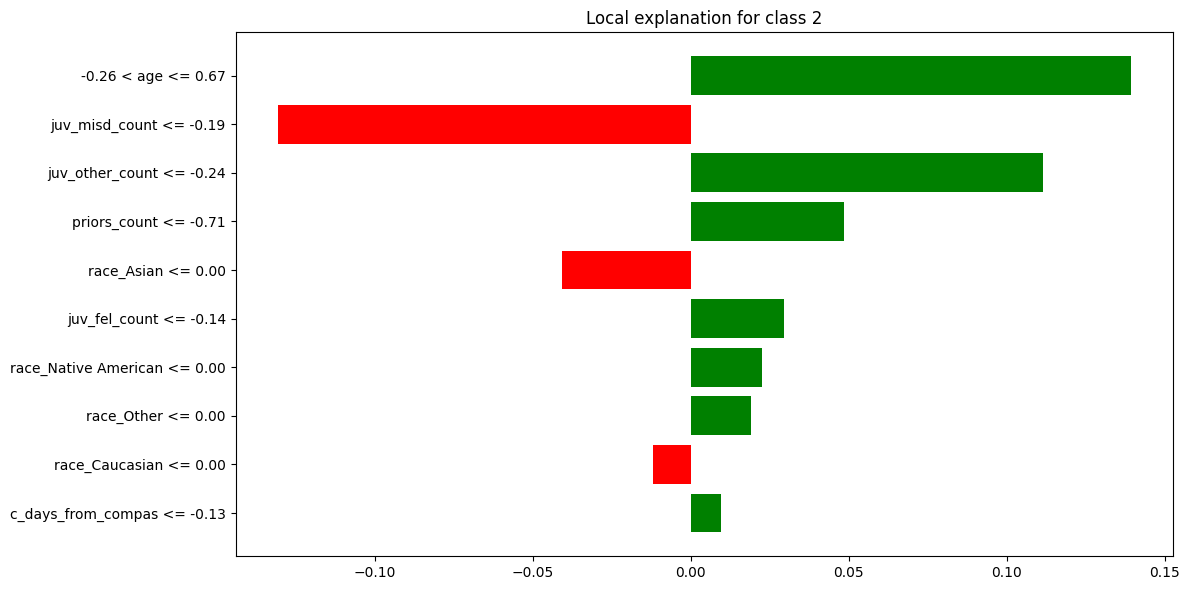

In [19]:
from lime.lime_tabular import LimeTabularExplainer
import numpy as np

# Setup LIME Explainer
explainer = LimeTabularExplainer(
    training_data=preprocessor.transform(X),
    feature_names=numerical_features + list(preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features)),
    class_names=[str(i) for i in tabular_model.classes_],
    mode='classification'
)

# Selecting an random instance 
idx = 1
instance = X.iloc[idx]
print("Instance Race:", instance['race'])
print("Instance Priors:", instance['priors_count'])
print("True Decile:", instance['v_decile_score'])

instance_trans = preprocessor.transform(X.iloc[[idx]])[0]
exp = explainer.explain_instance(instance_trans, tabular_model.named_steps['classifier'].predict_proba)
fig = exp.as_pyplot_figure()
fig.set_size_inches(12, 6) 
fig.patch.set_facecolor('white')
plt.tight_layout()
plt.show()

**LIME Interpretation**:
LIME evaluations show that features like `priors_count` and `age` heavily influence risk scores. While `race` is not a direct heavy weight (or arguably shouldn't be used at all), the correlation of other features (like zip codes or systemically biased prior counts) with race leads to disparate outcomes. This highlights that simply excluding `race` is insufficient for fairness.

## Fairness Mitigation
To improve the fairness of our surrogate model, we will apply the **Exponentiated Gradient** mitigation algorithm from `fairlearn`. We aim to minimize **Demographic Parity Difference** (to equalize selection rates across racial groups) while maintaining predictive accuracy.


--- Mitigated Surrogate Fairness Metrics ---
                  Selection Rate       FPR
race                                      
African-American        0.187323  0.167924
Caucasian               0.169756  0.157846


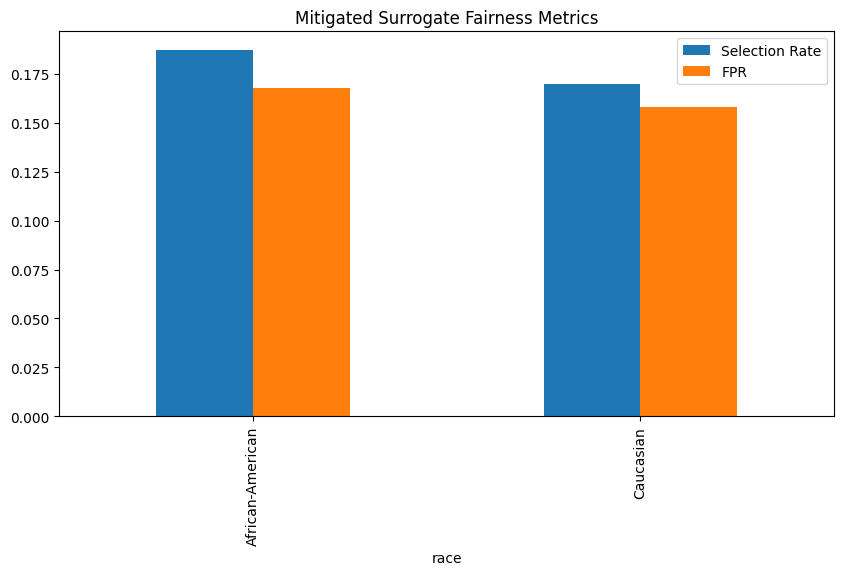

In [ ]:
from fairlearn.reductions import ExponentiatedGradient, DemographicParity
from sklearn.linear_model import LogisticRegression


#Preparing Data for Mitigation

mitigator = ExponentiatedGradient(
    estimator=LogisticRegression(solver='liblinear', random_state=67),
    constraints=DemographicParity()
)

# Training Mitigated Model
#Passing sensitive feature explicitly
X_trans = preprocessor.transform(X)
y_binary = (y > 5).astype(int)
mitigator.fit(X_trans, y_binary, sensitive_features=X['race'])

# Making Predictions
y_pred_mitigated = mitigator.predict(X_trans)
df_clean['mitigated_score'] = y_pred_mitigated

# Evaluate Mitigated Model
print("\n--- Mitigated Surrogate Fairness Metrics ---")
eval_mitigated = df_clean[df_clean['race'].isin(['African-American', 'Caucasian'])].copy()
mf_mitigated = MetricFrame(metrics={'Selection Rate': selection_rate, 'FPR': false_positive_rate}, 
                           y_true=eval_mitigated['is_violent_recid'], 
                           y_pred=eval_mitigated['mitigated_score'], 
                           sensitive_features=eval_mitigated['race'])
print(mf_mitigated.by_group)
mf_mitigated.by_group.plot(kind='bar', figsize=(10, 5), title="Mitigated Surrogate Fairness Metrics")
plt.show()

### Mitigation Results
By applying the `ExponentiatedGradient` with a `DemographicParity` constraint, we aimed to equalize the selection rates between African-American and Caucasian defendants. The resulting metrics should show a reduced gap in 'Selection Rate' compared to the unmitigated surrogate model, though potentially at a small cost to overall accuracy.

### Limitations
1. **Surrogate Approximation**: Our analysis is based on a surrogate model, which is an approximation of the actual COMPAS black-box. While it mimics COMPAS behavior (as seen in Section 1), it may not capture all non-linear complexities or exact decision boundaries used by the proprietary software.
2. **Data Bias**: The training data itself (`true_violent_recidivism.csv`) reflects historical arrests and convictions, which can be systemicallly biased. Mitigating model predictions doesn't fix the underlying data bias.
3. **Static vs Dynamic**: This analysis treats recidivism risk as a static prediction problem, whereas human behavior and rehabilitation potential are dynamic.

### Courtroom Recommendation
**I would NOT advise using even this refined surrogate model in courtrooms.**
Even with fairness mitigation:
- High stakes decisions (denying bail/parole) require individual justice, not just statistical group fairness.
- The "Ground Truth" label itself is a proxy (rearrest), not actual reoffending (crimes committed but not caught).
- Automating these decisions risks cementing historical prejudices, as seen in the high False Positive Rates for Black defendants that persist in historical patterns.

In [10]:

import joblib
import os


if not os.path.exists('models'):
    os.makedirs('models')

joblib.dump(tabular_model, 'models/tabular_model.pkl')
joblib.dump(text_model, 'models/text_model.pkl')
joblib.dump(meta_model, 'models/meta_model.pkl')
joblib.dump(preprocessor, 'models/preprocessor.pkl')
print("Models saved successfully!")

Models saved successfully!
